# Hyperparameter tuning with Ray Tune

Here using the MNIST dataset and the Pytorch model, the learning rate and decay are tuned.

In [1]:
from pathlib import Path
import numpy as np

# Import pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import ray modules
import ray
from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

In [2]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

# net = SimpleConvNet()
# input_data = torch.randn(1, 1, 28, 28)
# output = net(input_data)
# print(output)

In [3]:
# Change these values if you want the training to run quicker or slower.
# EPOCH_SIZE = 512
# TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        # if batch_idx * len(data) > EPOCH_SIZE:
        #     return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            # if batch_idx * len(data) > TEST_SIZE:
            #     break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total * 100

In [4]:
def train_mnist(config: dict):
    data_path = config["data_path"]
    # Data Setup
    mnist_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307, ), (0.3081, ))
        ]
    )

    train_loader = DataLoader(
        datasets.MNIST(data_path, train=True, download=True, transform=mnist_transforms),
        batch_size=256,
        shuffle=True
    )
    test_loader = DataLoader(
        datasets.MNIST(data_path, train=False, transform=mnist_transforms),
        batch_size=256,
        shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SimpleConvNet()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        session.report({"mean_accuracy": acc})

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [5]:
data_path = Path.cwd().parent / "data"
data_path.mkdir(exist_ok=True, parents=True)
print(f"Data path: {data_path}")

search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "weight_decay": tune.uniform(0.1, 0.9),
    "data_path": str(data_path), # Not a hyperparameter
}

# Uncomment this to enable distributed execution
ray.init()

# Download the dataset first
datasets.MNIST(data_path, train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=10,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    )
)
results = tuner.fit()

(train_mnist pid=14084) Caught sync error: Sync process failed: GetFileInfo() yielded path 'C:/Users/lcglab/ray_results/train_mnist_2023-07-25_17-08-12/train_mnist_66564_00005_5_weight_decay=0.4957_2023-07-25_17-08-12/events.out.tfevents.1690272502.DESKTOP-TSBOB2F', which is outside base dir 'C:\Users\lcglab\ray_results\train_mnist_2023-07-25_17-08-12\train_mnist_66564_00005_5_weight_decay=0.4957_2023-07-25_17-08-12\'. Retrying after sleeping for 1.0 seconds...
(train_mnist pid=14084) Could not upload checkpoint to c://\Users\lcglab\ray_results\train_mnist_2023-07-25_17-08-12\train_mnist_66564_00005_5_weight_decay=0.4957_2023-07-25_17-08-12 even after 3 retries.Please check if the credentials expired and that the remote filesystem is supported. For large checkpoints or artifacts, consider increasing `SyncConfig(sync_timeout)` (current value: 1800 seconds).
2023-07-25 17:11:39,678	WARNING tune.py:1122 -- Trial Runner checkpointing failed: Sync process failed: GetFileInfo() yielded path 

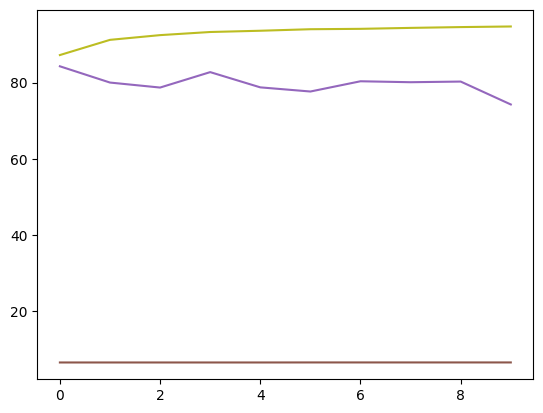

In [6]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax)